### Atividade de Classificadores
database: [League of Legends Diamond Ranked Games (10 min)](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min)

Resumo da Atividade
Nesta atividade, foi utilizado o conjunto de dados League of Legends Diamond Ranked Games (10 min), que contém informações extraídas dos primeiros 10 minutos de partidas ranqueadas de alto nível do jogo League of Legends.

O objetivo foi aplicar e comparar diferentes classificadores supervisionados para prever o resultado da partida (vitória ou derrota) com base em métricas como ouro, abates, torres destruídas e outros indicadores de desempenho de equipe.

Foram implementados e analisados três algoritmos de aprendizado de máquina:
- KNN (K-Nearest Neighbors) — baseado na similaridade entre amostras.
- SVM (Support Vector Machine) — busca o hiperplano que melhor separa as classes.
- Random Forest — utiliza múltiplas árvores de decisão para melhorar a precisão e reduzir o overfitting.

Os modelos foram avaliados por meio de validação cruzada (5-fold cross-validation), utilizando métricas de desempenho como Acurácia, Precisão, Recall e F1-Score.

Também foram realizados ajustes de hiperparâmetros (GridSearchCV) para otimizar cada modelo antes da comparação final.


Métricas utilizadas:
- Accuracy: proporção de acertos
- Precision: precisão na predição da classe positiva
- Recall: cobertura da classe positiva
- F1 Score: média harmônica entre precision e recall
- Validação cruzada 5-fold: garante avaliação robusta e evita overfitting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Carregar o dataset em um dataframe
df = pd.read_csv('../../datasets/high_diamond_ranked_10min.csv')

# Verificar quais são as colunas existentes no dataframe
pd.DataFrame(np.array(df.columns).reshape(-1, 4), columns=[f'Col{i+1}' for i in range(4)])

,Col1,Col2,Col3,Col4
0,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed
1,blueFirstBlood,blueKills,blueDeaths,blueAssists
2,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed
3,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled
4,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin
5,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood
6,redKills,redDeaths,redAssists,redEliteMonsters
7,redDragons,redHeralds,redTowersDestroyed,redTotalGold
8,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
9,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin


In [3]:
# Verificar a existência de valores nulos no dataframe
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if not missing.empty:
    print("Valores nulos por coluna:")
    print(missing)
else:
    print("Valores nulos não detectados.")

# Verificar a existência de dados duplicados no dataframe
duplicates = df.duplicated().sum()
print(f"Quantidade de linhas duplicadas: {duplicates}")

Valores nulos não detectados.
Quantidade de linhas duplicadas: 0


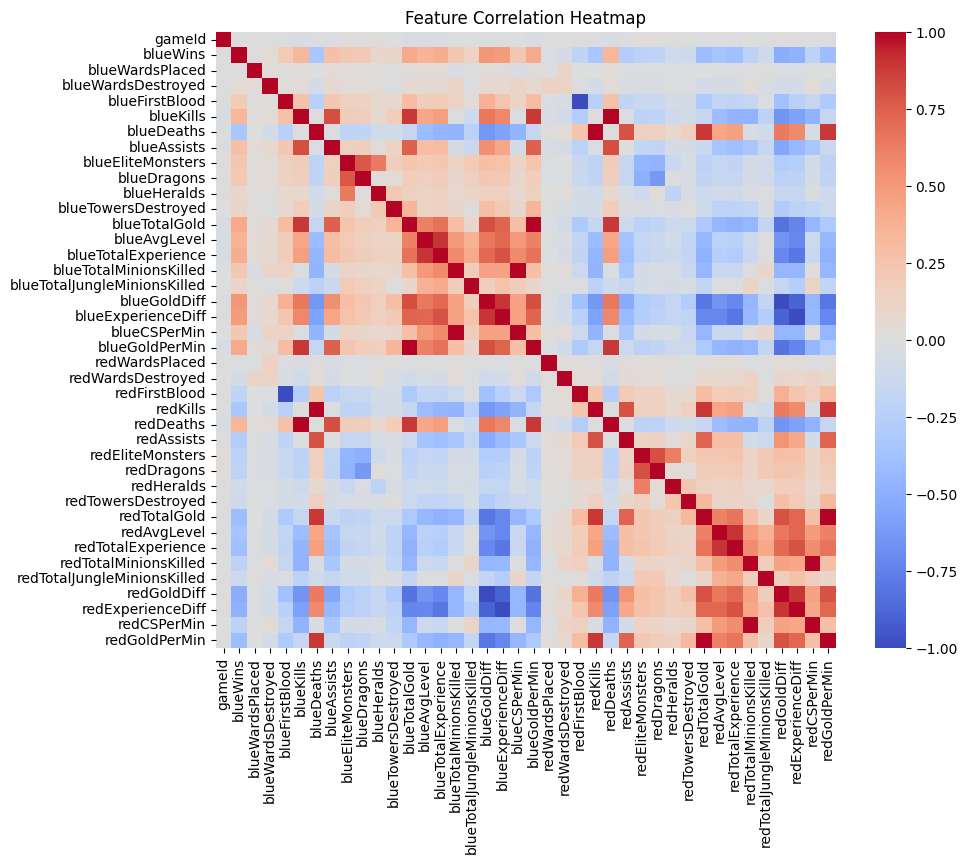

In [4]:
# Criar um heatmap mostrando a correlação entre os dados do dataframe
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [5]:
# Normalizar dados do dataframe
scaler = MinMaxScaler()

X = df.drop(['blueWins', 'gameId'], axis=1)
y = df['blueWins']

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled.describe().T[['min', 'max']]

,min,max
blueWardsPlaced,0.0,1.0
blueWardsDestroyed,0.0,1.0
blueFirstBlood,0.0,1.0
blueKills,0.0,1.0
blueDeaths,0.0,1.0
blueAssists,0.0,1.0
blueEliteMonsters,0.0,1.0
blueDragons,0.0,1.0
blueHeralds,0.0,1.0
blueTowersDestroyed,0.0,1.0


### KNN - GridSearchCV

- Busca dos melhores parâmetros de KNN usando validação cruzada 5-fold
- Métricas de avaliação: Accuracy, Precision, Recall, F1-Score

In [13]:
# KNN
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42, stratify=y)

# Define o espaço de busca de hiperparâmetros
param_grid = {
    'n_neighbors': range(1, 21),            # testar de 1 a 20 vizinhos para a predição
    'weights': ['uniform', 'distance'],     # uniform(todos os vizinhos tem peso igual) 
                                            # distance(vizinhos mais próximos tem mais peso)
    'p': [1, 2]                             # 1 = Manhattan(soma das diferenças absolutas) 
                                            # 2 = Euclidean distance(distância “normal”)
}

# KNN
knn_model = KNeighborsClassifier()

# Configura o Grid Search com validação cruzada (5-fold)
grid_search_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Treina o modelo usando a busca de hiperparâmetros
grid_search_knn.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados para o KNN:")
print(grid_search_knn.best_params_)

# Realizar testes com os melhores parâmetros
best_knn = grid_search_knn.best_estimator_
y_pred = best_knn.predict(X_test)

results_knn = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

results_knn_df = pd.DataFrame([results_knn], index=['KNN'])
results_knn_df.style.background_gradient(cmap='Blues', axis=None)

Melhores parâmetros encontrados para o KNN:
{'n_neighbors': 17, 'p': 1, 'weights': 'distance'}


,Accuracy,Precision,Recall,F1 Score
KNN,0.705612,0.697221,0.724647,0.710669


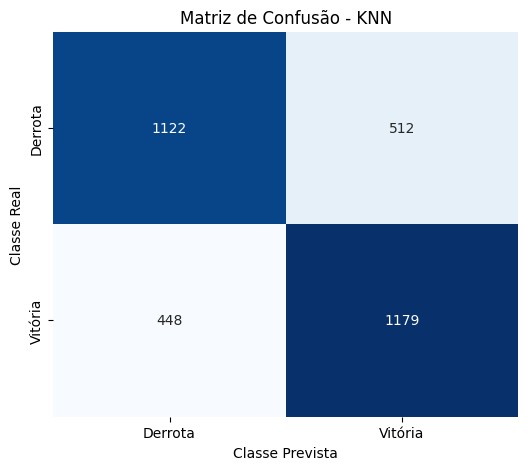

In [7]:
# Matriz de confusão KNN
plt.figure(figsize=(6,5))
classes = ['Derrota', 'Vitória']
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - KNN')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

### SVM - GridSearchCV

- Busca dos melhores parâmetros de SVM usando validação cruzada 5-fold
- Kernel, C e gamma ajustados

In [8]:
# SVM
svm_model = SVC(random_state=42)

# Define o espaço de busca de hiperparâmetros
param_grid = {
    'C': [0.1, 1, 10],                                  # controla a penalização dos erros (regularização)
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],     # tipos de função de kernel
    'gamma': ['scale', 'auto']                          # controla a influência de cada ponto de treinamento
}

# Configura o Grid Search com validação cruzada (5-fold)
grid_search_svm = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Treina o modelo usando a busca de hiperparâmetros
grid_search_svm.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados para o SVM:")
print(grid_search_svm.best_params_)

# Usa o melhor modelo encontrado para fazer previsões
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

results_svm = {
    'Accuracy': [accuracy_score(y_test, y_pred_svm)],
    'Precision': [precision_score(y_test, y_pred_svm)],
    'Recall': [recall_score(y_test, y_pred_svm)],
    'F1 Score': [f1_score(y_test, y_pred_svm)]
}

results_svm_df = pd.DataFrame(results_svm, index=['SVM'])
display(results_svm_df.style.background_gradient(cmap='Blues', axis=None))

Melhores parâmetros encontrados para o SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


,Accuracy,Precision,Recall,F1 Score
SVM,0.721864,0.716086,0.733251,0.724567


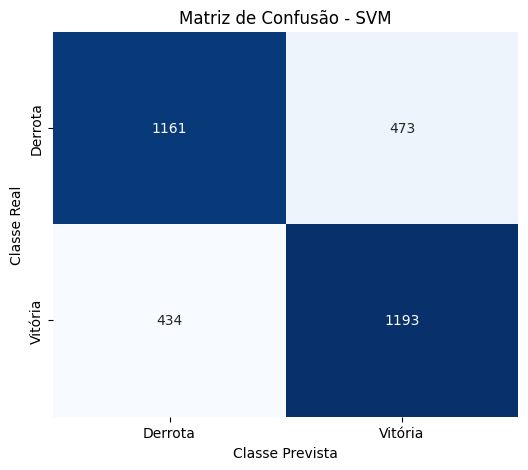

In [9]:
# Matriz de confusão SVM
plt.figure(figsize=(6,5))
classes = ['Derrota', 'Vitória']
sns.heatmap(confusion_matrix(y_test, y_pred_svm), 
            annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

### Random Forest - GridSearchCV

- Busca dos melhores parâmetros de Random Forest usando validação cruzada 5-fold
- n_estimators, max_depth, min_samples_split e min_samples_leaf ajustados

In [10]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Define o espaço de busca de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],   # número de árvores na floresta
    'max_depth': [10, 20, 30, None],   # profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],   # mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],     # mínimo de amostras por folha
    'bootstrap': [True, False]         # se o bootstrap será usado ao construir as árvores
}

# Configura o Grid Search com validação cruzada (5-fold)
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Treina o modelo usando a busca de hiperparâmetros
grid_search_rf.fit(X_train, y_train)

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados para o Random Forest:")
print(grid_search_rf.best_params_)

# Usa o melhor modelo encontrado para fazer previsões
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

results_rf = {
    'Accuracy': [accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_rf)],
    'F1 Score': [f1_score(y_test, y_pred_rf)]
}

results_rf_df = pd.DataFrame(results_rf, index=['Random Forest'])
results_rf_df.style.background_gradient(cmap='Blues', axis=None)

Melhores parâmetros encontrados para o Random Forest:
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


,Accuracy,Precision,Recall,F1 Score
Random Forest,0.719718,0.714888,0.728949,0.721850


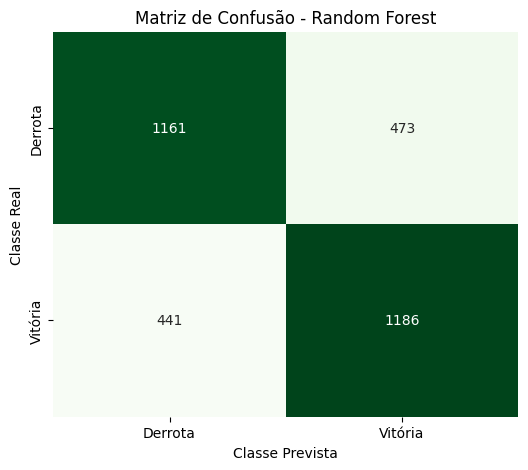

In [11]:
# Matriz de confusão Random Forest
plt.figure(figsize=(6,5))
classes = ['Derrota', 'Vitória']
sns.heatmap(confusion_matrix(y_test, y_pred_rf), 
            annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

### 5-fold Cross Validation


Comparação dos Modelos (5-Fold Cross-Validation)
           Model  Accuracy  Precision  Recall  F1 Score
2  Random Forest    0.7303     0.7316  0.7262    0.7288
1            SVM    0.7282     0.7302  0.7225    0.7263
0            KNN    0.7174     0.7193  0.7116    0.7153


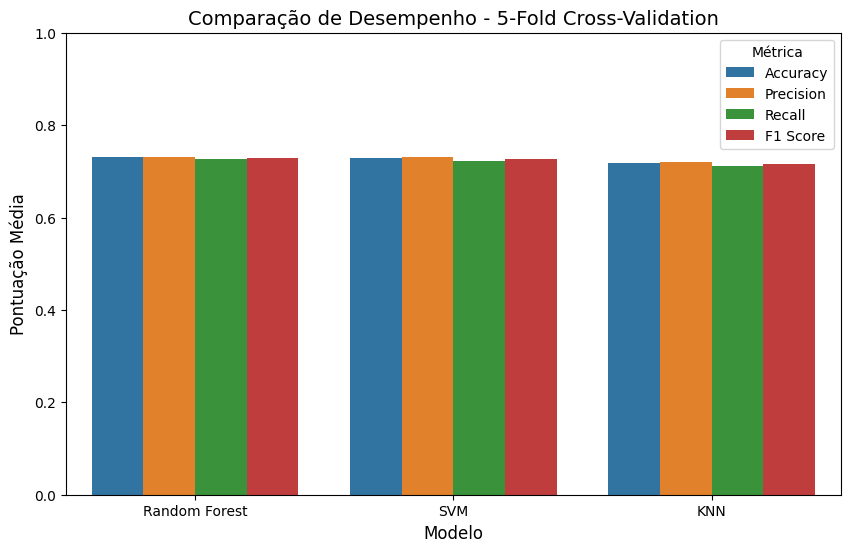

In [ ]:
models = {
    'KNN': grid_search_knn.best_estimator_,
    'SVM': grid_search_svm.best_estimator_,
    'Random Forest': grid_search_rf.best_estimator_
}

# Definir métricas para validação cruzada
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Executar 5-Fold Cross Validation para cada modelo
results = []

for name, model in models.items():
    cv_res = cross_validate(model, X_scaled, y, cv=5, scoring=scoring)
    results.append({
        'Model': name,
        'Accuracy': np.mean(cv_res['test_accuracy']),
        'Precision': np.mean(cv_res['test_precision']),
        'Recall': np.mean(cv_res['test_recall']),
        'F1 Score': np.mean(cv_res['test_f1'])
    })

# Exibir resultados em tabela
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print("Comparação dos Modelos (5-Fold Cross-Validation)")
print(results_df.round(4))

# Gráfico comparativo de métricas
plt.figure(figsize=(10,6))
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title('Comparação de Desempenho - 5-Fold Cross-Validation', fontsize=14)
plt.ylabel('Pontuação Média', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.legend(title='Métrica')
plt.show()

### Conclusões

Após a aplicação dos classificadores KNN, SVM e Random Forest com ajuste de hiperparâmetros e validação cruzada 5-fold, obtivemos os seguintes resultados:

| Modelo      | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
|Random Forest|	0.7303   | 0.7316    | 0.7262 | 0.7288   |
|SVM          | 0.7282   | 0.7302    | 0.7225 | 0.7263   |
|KNN          | 0.7174   | 0.7193    | 0.7116 | 0.7153   |

Análise:
1. Random Forest apresentou o melhor desempenho geral, obtendo as maiores médias em todas as métricas, destacando-se como o modelo mais robusto para esse conjunto de dados.
2. SVM teve desempenho muito próximo ao Random Forest, sendo uma boa alternativa quando se deseja um modelo linear ou de menor complexidade computacional para dados com muitas características.
3. KNN apresentou resultados ligeiramente inferiores, mas ainda razoáveis, sendo mais sensível à escolha de hiperparâmetros e à escala dos dados.

Observações importantes:
- O ajuste de hiperparâmetros via GridSearchCV foi essencial para maximizar a performance de cada modelo.
- A utilização de validação cruzada 5-fold permitiu uma avaliação mais confiável e robusta, evitando sobreajuste aos dados de treino.
- As métricas de precisão, recall e F1-score mostram que todos os modelos mantêm um bom equilíbrio entre identificar corretamente vitórias e derrotas.

Conclusão final:
Para este dataset de partidas de League of Legends, o Random Forest é o modelo mais indicado, fornecendo o melhor compromisso entre acurácia e estabilidade na predição dos resultados das partidas.